In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:

import os
import sys
sys.path.append(f"{os.getcwd()}/../src")
import adv

In [4]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:1


### Load in the dataset + initialize a new classifier

In [5]:
ds = adv.ZJetsDataset(device=device, use_cache=True, dir="../data/adv")

n_train = int(0.8*len(ds))
n_val = len(ds)-n_train

ds_train, ds_val = torch.utils.data.random_split(ds, (n_train, n_val))

x_train, y_train = ds_train[:100000] # using fewer samples because it's VERY slow...
x_val, y_val = ds_val[:]

In [72]:
# we are going to train a new classifier from scratch

model = adv.JetClassifier().to(device)
model.loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters())

h = {}

# you can also load a partly pre-trained one here:
# model = torch.load('classifier1.pt', map_location=device)

## Training with Madry regularizaion
In order to protect our networks against "first order" aversaries, we are going to implement a modified training method. This method proposed by Madry et al. in "Towards Deep Learning Models Resistant to Adversarial Attacks" ([1706.06083](https://arxiv.org/abs/1706.06083)), has been shown to be effective against generic first order adversaries, under certain conditions.

What is very unique about the method is that during training, *the model never sees any of the real training data*.

The basic idea is that in order to protect against a generic adversary, we should insert an adversary in the training loop.
At the beginning of each batch, we use the iterative FGSM/PGD method in order to estimate the worst-case perturbation of each example in the batch.
We then present the adversarially-perturbed example to the target network, and *still expect it to get the right answer*.

In other words, when we train the network to always get the correct answer even when presented with perturbed data, it should be more robust to such adversaries.

In order to get a better estimate of the *worst-case* example, we use a more sophisticated iterative PGD method, implemented in adv.py.
We won't have time to go over it in detail, but the main differences are:

  * each perturbation is initialized at a random nearby point
  * each "real" example is subjected to many attacks in parallel (i.e. dozens or hundreds, limited by on GPU memory)
  * only the attack with the greatest increase in classification loss is shown
  * step sizes are more tunable
  * at every step, each perturbed example is forced to remain within an absolute distance from the original.

In [60]:
epochs = 8

batch_size = 1024
val_batch_size = 2048

n_iter = 8 # number of PGD iterations to do for each batch
n_trials = 16 # number of PGD trials to do in parallel for each example.

epsilons = (1e-1, 1e-1, 1e-1) # absolute maximum differences allowed in (pt,eta,phi)
alphas = (1e-2, 5e-3, 5e-3) # step size in (pt,eta,phi) at each iteration of PGD.

nbatch_train = x_train.shape[0]//batch_size
nbatch_val = x_val.shape[0]//val_batch_size

for ep in range(epochs):
    running_loss = 0
    running_acc = 0
        
    # shuffle the data indices
    idxs = torch.randperm(x_train.shape[0], device=device)
    
    print("Training epoch", ep)
    
    for ib in range(nbatch_train):
        if ib%25==0:
            print("  Batch %d/%d" % (ib, nbatch_train))
        bidx = idxs[ib*batch_size:(ib+1)*batch_size]
        
        # x0 is the original, unperturbed image (that our network will not see).
        x0, y = x_train[bidx], y_train[bidx]
        
        # first, we synthesize a batch of perturbed examples. only the worst example
        # for each entry in the batch is kept.
        model.eval()
        x1 = adv.pgd_attack(model, x0, y, n_iter=n_iter, n_trials=n_trials, eps=epsilons, alpha=alphas)
        
        # now we train the model as usual, but using the adversarial input:
        model.train()
        optimizer.zero_grad()
        
        outputs = model(x1)
        running_acc += (torch.max(outputs, axis=1)[1] == y).sum().item()
        
        loss = model.loss_fn(outputs, torch.squeeze(y,axis=-1)).mean()
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    running_loss /= (len(x_train)//batch_size)
    running_acc /= len(x_train)
    
    model.eval()
    with torch.no_grad():
        val_acc = 0
        val_loss = 0

        for ib in range(nbatch_val):
            x = x_val[ib*val_batch_size:(ib+1)*val_batch_size]
            y = y_val[ib*val_batch_size:(ib+1)*val_batch_size]
            output = model(x)
            loss = model.loss_fn(output, y).mean()
            val_loss += loss.item()
            val_acc += (torch.max(output,axis=1)[1] == y).sum().item()
        val_loss /= nbatch_val
        val_acc /= nbatch_val*val_batch_size
    
    print("    loss: %.4f   acc: %.3f    val_loss: %.4f   val_acc: %.3f" % (running_loss, running_acc, val_loss, val_acc))
    
    h.setdefault('loss', []).append(running_loss)
    h.setdefault('acc', []).append(running_acc)
    h.setdefault('val_loss', []).append(val_loss)
    h.setdefault('val_acc', []).append(val_acc)

Training epoch 0
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6743   acc: 0.563    val_loss: 0.6735   val_acc: 0.570
Training epoch 1
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6740   acc: 0.564    val_loss: 0.6732   val_acc: 0.571
Training epoch 2
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6737   acc: 0.565    val_loss: 0.6735   val_acc: 0.570
Training epoch 3
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6738   acc: 0.564    val_loss: 0.6733   val_acc: 0.571
Training epoch 4
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6736   acc: 0.564    val_loss: 0.6729   val_acc: 0.572
Training epoch 5
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6737   acc: 0.565    val_loss: 0.6734   val_acc: 0.570
Training epoch 6
  Batch 0/97
  Batch 25/97
  Batch 50/97
  Batch 75/97
    loss: 0.6736   acc: 0.565    val_loss: 0.6732   val_acc: 0.573
Training epoch 7
  Batch 0/

In [71]:
#torch.save(model, 'classifier_adv.pt')

In [61]:
npred = 2048 # reduce if you're out of GPU memory
with torch.no_grad():
    model.eval()
    pred_val = torch.softmax(model(x_val[:npred]), axis=-1)[:,1].cpu().numpy()

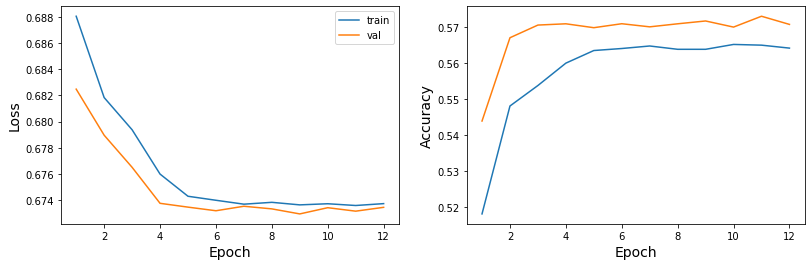

In [62]:
plt.figure(figsize=plt.figaspect(0.3))
xep = np.arange(len(h['loss']))+1
plt.subplot(121)
plt.plot(xep, h['loss'], label='train')
plt.plot(xep, h['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(xep, h['acc'], label='train')
plt.plot(xep, h['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

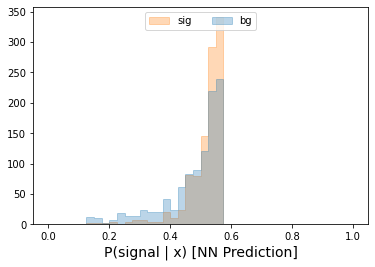

In [63]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=40, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig']);
plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

## Try PGD attack on madry-trained network

In [64]:
n_attack = 2048

epsilon = 1e-1

x_test = x_val[:n_attack]
y_test = y_val[:n_attack]

#x_adv = adv.fgsm_attack(model, x_test, y_test, epsilon=1e-1)
x_adv = adv.pgd_attack(model, x_test, y, n_iter=4, n_trials=8, eps=epsilons, alpha=alphas)
print(x_adv.shape)

torch.Size([2048, 64, 3])


In [65]:
with torch.no_grad():
    pred_adv = torch.softmax(model(x_adv), axis=-1)[:,1].cpu().numpy()

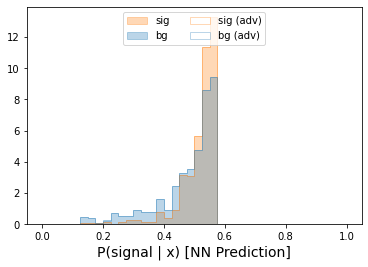

In [66]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=40, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig'], density=True);

plt.hist([pred_adv[y_test.cpu()==0], pred_adv[y_test.cpu()==1]],
         histtype='step', bins=40, range=(0,1), alpha=0.3, color=['C0','C1'], label=['bg (adv)', 'sig (adv)'], density=True);

plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

The accuracy is not affected at all by the adversarial attack! But unfortuately, the performance is little better than a coin toss :(

In [67]:
acc_before = np.mean((pred_val>0.5)==y_val[:npred].cpu().numpy())
acc_after = np.mean((pred_adv>0.5)==y_test.cpu().numpy())

print("Accuracy before: %.3f" % acc_before)
print("Accuracy after:  %.3f" % acc_after)

Accuracy before: 0.594
Accuracy after:  0.594


### Visualize the changes made by the adversary:
The top row shows jets and their classifier scores, before the adversarial perturbation. The bottom row show the same jets after.


Notice that sometimes **the adversary makes substantial changes to the input***, but the **classifier's response is not affected!**

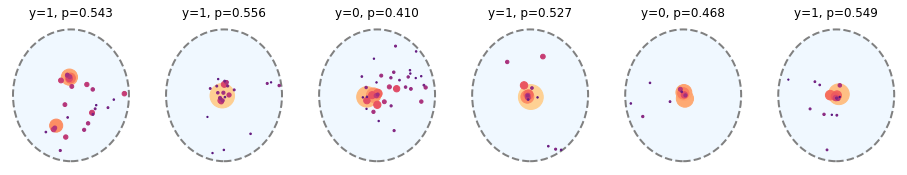

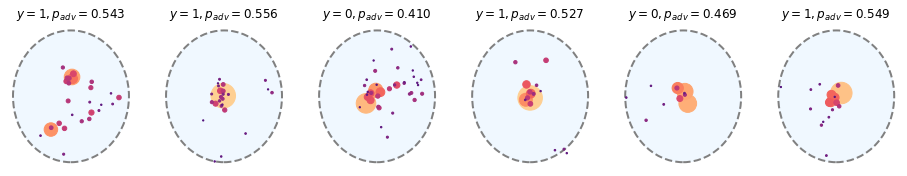

In [68]:
nshow = 6

plt.figure(figsize=plt.figaspect(1/nshow))

offset = 10

for i in range(nshow):
    j0 = adv.center(x_test[i+offset][x_test[i+offset,:,0]>0]).cpu().numpy()
    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j0[:,1], j0[:,2], s=(j0[:,0]*3e3)**1., cmap='magma', c=np.log(j0[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.title("y=%d, p=%.3f" % (y_test[i+offset], pred_val[i+offset]))

plt.figure(figsize=plt.figaspect(1/nshow))
for i in range(nshow):
    j0 = adv.center(x_adv[i+offset][x_adv[i+offset,:,0]>0]).cpu().numpy()
    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j0[:,1], j0[:,2], s=(j0[:,0]*3e3)**1., cmap='magma', c=np.log(j0[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.title(r"$y=%d, p_{adv}=%.3f$" % (y_test[i+offset], pred_adv[i+offset]))

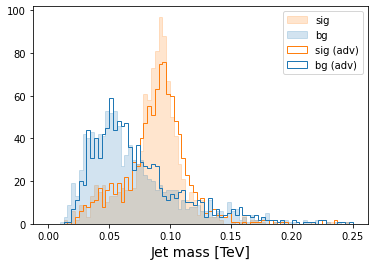

In [69]:
# convert particles to jets
j_test = adv.to_jet(x_test).cpu().numpy()
j_adv = adv.to_jet(x_adv).cpu().numpy()

plt.hist([j_test[y_test.cpu()==0,3], j_test[y_test.cpu()==1,3]], histtype='step', bins=80, range=(0,0.25), fill=True, alpha=0.2, color=['C0','C1'], label=['bg','sig']);
plt.hist([j_adv[y_test.cpu()==0,3], j_adv[y_test.cpu()==1,3]], histtype='step', bins=80, range=(0,0.25), color=['C0','C1'], label=['bg (adv)','sig (adv)']);
plt.xlabel("Jet mass [TeV]")
plt.legend();

## Conclusion / Shameless plug
Madry regularization can be very effective at achiving robustness to modeling uncertainties... however, it can come with a steep price!

In particular, our notion of a "small" change in pt/eta/phi at the per-particle level can add up to very non-small changes in physically-relevant observables.

In our paper (significant revision forthcoming), Ben Nachman and I are using these methods explore how we can leverage physics domain knowledge to define a more refined "perturbation space". This reduces the attack surface to include only physically meaningful and/or plausible mismodelling effects, allowing us to demonstrate robustness without sacrificing as much performance! See [arXiv:1910.08606](https://arxiv.org/abs/1910.08606) for more details :)